In [140]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
from databasing.conn_strings import db_conn_string
import matplotlib.pyplot as plt
import ipywidgets as widgets

conn = create_engine(db_conn_string)
ts_figsize = (12, 5)  # default shape of any timeseries plots

In [141]:
get_lifts = 'SELECT lift_id FROM lifts WHERE test_lift IS NOT TRUE AND lift_id > 308'
l_ids = list(pd.read_sql(get_lifts, conn)['lift_id'].values)
print l_ids

[379, 380, 381, 382, 383, 327, 326, 328, 384, 385, 386, 387, 388, 329, 378, 373]


In [142]:
def max_min_norm(s):
    return s/(s.max() - s.min())

from databasing.database_pull import pull_data_by_lift
from processing.util import process_data

# lift_id to pull
lid = l_ids[0]
print 'Processing lift {}'.format(lid)

header, data = pull_data_by_lift(lid)

accel, vel, _, _, _ = process_data(header, data, RMS=False, highpass=False)
a, v, pwr, pos, force = process_data(header, data, RMS=False, highpass=True)
a_rms, _, _, _, _ = process_data(header, data, RMS=True, highpass=True)

Processing lift 379


In [143]:
print 'mean:   {m1} \nmedian: {m2}'.format(m1=a_rms.mean()['rms'], m2=a_rms.median()['rms'])
print 'SNR:    {}'.format((a_rms.median() / a_rms.var())['rms'])

mean:   1.77908877549 
median: 0.972112735559
SNR:    0.245838111767


In [144]:
# normalize accel
for k in a.keys():
    key = k + '_norm'
    a[key] = max_min_norm(a[k])

# normalize velocity
for k in v.keys():
    key = k + '_norm'
    v[key] = max_min_norm(v[k])

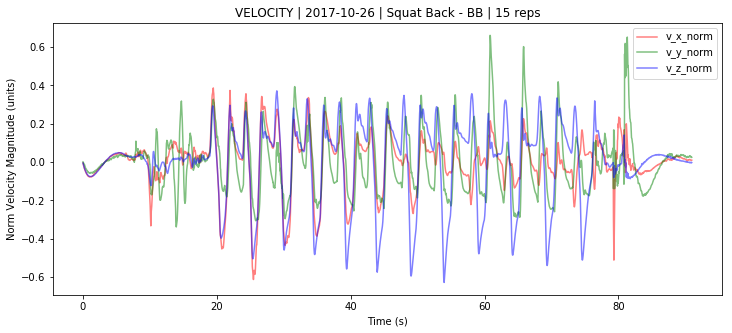

In [145]:
colors = ['red', 'green', 'blue']
norm_keys = sorted([k for k in v.keys() if '_norm' in k])
nn_keys = sorted([k for k in v.keys() if '_norm' not in k])
key_with_color = zip(colors, norm_keys)

plt.figure(figsize=ts_figsize)
for c, lab in key_with_color:
    plt.plot(data['timepoint'], v[lab], color=c, alpha=0.5, label=lab)

# TODO - fix the SQL query
i_reps, f_reps = header['init_num_reps'], header['final_num_reps']
n_reps = f_reps if f_reps is not None else i_reps
title = 'VELOCITY' + ' | ' + str(header['created_at'].date()) + ' | ' + header['lift_type'] + ' | ' + str(n_reps) + ' reps'
plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Norm Velocity Magnitude (units)')
_ = plt.legend()

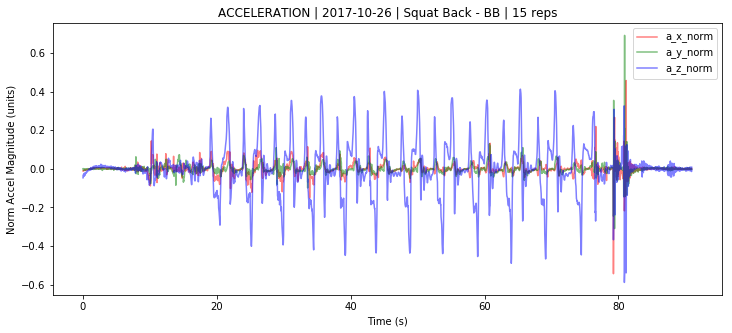

In [146]:
norm_keys = sorted([k for k in a.keys() if ('_norm' in k) and ('a' in k)])
nn_keys = sorted([k for k in a.keys() if ('_norm' not in k) and ('a' in k)])
key_with_color = zip(colors, norm_keys)

plt.figure(figsize=ts_figsize)
for c, lab in key_with_color:
    plt.plot(data['timepoint'], a[lab], color=c, alpha=0.5, label=lab)

# TODO - fix the SQL query
i_reps, f_reps = header['init_num_reps'], header['final_num_reps']
n_reps = f_reps if f_reps is not None else i_reps
title = 'ACCELERATION' + ' | ' + str(header['created_at'].date()) + ' | ' + header['lift_type'] + ' | ' + str(n_reps) + ' reps'
plt.title(title)
plt.xlabel('Time (s)')
plt.ylabel('Norm Accel Magnitude (units)')
plt.legend()

mean: {u'a_z': -0.38722710622710621, u'a_y': 0.053476190476190469, u'a_x': -0.12493040293040293}
var:  {u'a_z': 6.201322429166046, u'a_y': 0.24225170793418135, u'a_x': 0.89521752904967278}
SNR:  {u'a_z': -0.15549756565377756, u'a_y': 0.10864932629415296, u'a_x': -0.13203949418393662}


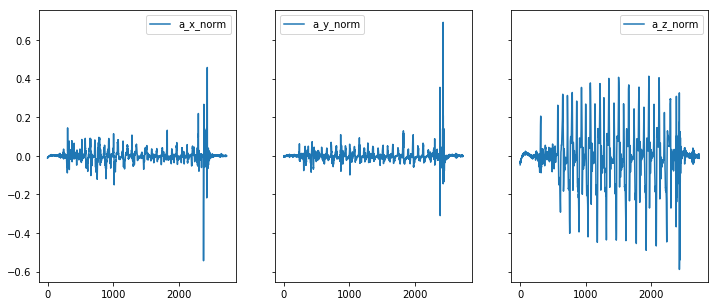

In [147]:
from scipy.stats import signaltonoise

offsets = {k: accel[k].mean() for k in nn_keys}
print 'mean: {}'.format(offsets)

var = {k: accel[k].var() for k in nn_keys}
print 'var:  {}'.format(var)

snr = {k: accel[k].mean()/accel[k].std() for k in nn_keys}
print 'SNR:  {}'.format(snr)

fig, axarr = plt.subplots(1, 3, sharey=True, figsize=ts_figsize)
for i, k in enumerate(norm_keys):
    axarr[i].plot(a[k], label=k)
    axarr[i].legend()

In [148]:
import matplotlib.mlab as ml
import numpy as np
import pandas as pd

# EXAMPLE run a single fft across entire signal
# returns power values p1 within frequencies f1
# p1, f1 = ml.psd(a['a_z'], nfft, 30., sides='onesided')
# plt.plot(f1, p1)

# build spectral estimate of signal
nfft=2**4
fs = float(header['sampling_rate'])  # sampling rate
N = len(a['a_z'])  # number of samples
w_size = int(fs)        # window size
step_size = int(np.ceil(fs/3.))  # number of points to step window over
n_steps = int(np.ceil(N/step_size))  # number of steps to cover entire signal, given step_size

means = []
variance = []
dat = pd.DataFrame()
for step in range(n_steps-1):
    acc = a['a_z'].iloc[(step*step_size):w_size + (step+1)*step_size]
    p, f = ml.psd(acc, nfft, fs, sides='onesided')
    dat = dat.append(pd.Series(p, index=f).T, ignore_index=True)
    means.append(acc.mean())
    variance.append(acc.var())
    
dat = dat.applymap(np.log10)
dat = dat.apply(lambda col: col - col.mean(), axis=0)
dat.head()

,0.0,1.875,3.75,5.625,7.5,9.375,11.25,13.125,15.0
0,-0.505927,-0.813592,-2.280012,-2.129145,-0.345216,-0.062262,-0.461736,-2.201709,-1.455868
1,-1.090217,-1.380499,-2.200410,-1.509142,-1.020227,-0.497481,-0.321036,-0.668345,-0.545259
2,-1.767172,-1.969422,-2.047832,-1.084955,-0.400926,-0.344659,-0.714723,-0.953249,-1.021909
3,-1.510261,-1.761316,-2.225404,-1.923686,-0.739384,-0.230681,-0.404265,-0.422583,-1.086148
4,-1.273971,-1.626315,-3.126843,-1.876392,-0.374822,-0.081536,-0.548602,-0.928340,-0.669194


21.4048721973


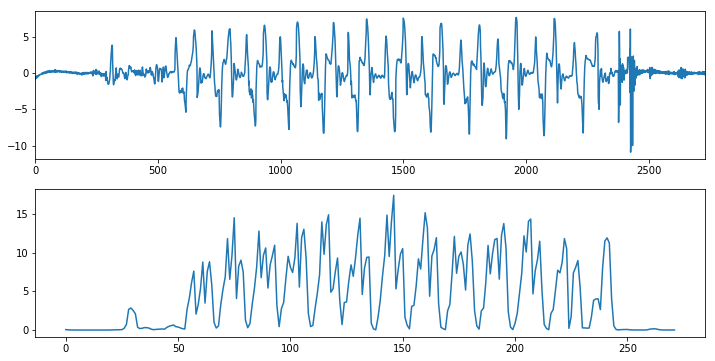

In [149]:
fig, axarr = plt.subplots(2, 1, figsize=(12, 6))
axarr[0].plot(a.index, a['a_z'])
axarr[0].set_xlim([0, len(a.index)])
# axarr[1].pcolormesh(dat.index, dat.columns,dat.T.values, cmap='viridis')
axarr[1].plot(variance)

print np.var(variance)